In [5]:
import astropy.io.fits as fits
import numpy as np
import random
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.tensor import fft
import theano.tensor.signal.conv

Enter the seed: 42
Enter the number of data points: 5000
Enter the start time of observation: 58000
Enter the end time of observation: 58900
Enter the timescale of variation for the driving function(ℓ_true=2*ℓ^2)[d^(1/2)]: 1.6
Enter the long term standard deviation for the driving function[d]: 1.0
Enter the exponent related to the PSD slope: 1.0
time values are saved as "X" and magnitude values are saved as "f_true"


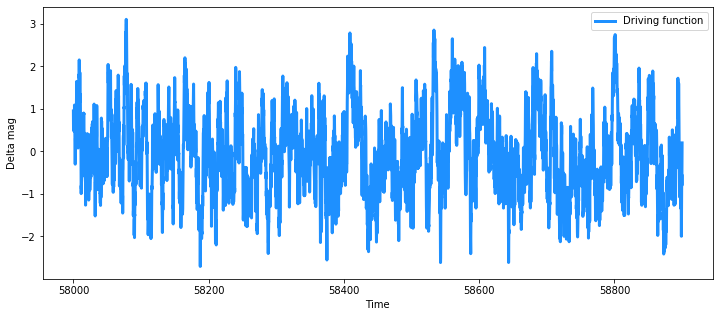

In [3]:
# set the seed
np.random.seed(int(input("Enter the seed: ")))

n = int(input("Enter the number of data points: "))
 # The number of data points
#ntau=10000.0 number of points for transfer function 
tau = np.linspace(0.0, 1000.0, n)#delay times for transfer function 
start = float(input("Enter the start time of observation: "))
end = float(input("Enter the end time of observation: "))
X = np.linspace(start, end, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = float(input("Enter the timescale of variation for the driving function(ℓ_true=2*ℓ^2)[d^(1/2)]: "))#timescale of variation for the driving function
#REMEMBER time scale is 2*ℓ^2 so remember to rewrite as ℓ_true=2*ℓ^2
η_true = float(input("Enter the long term standard deviation for the driving function[d]: "))#long term standard deviation for the driving function
α_true = float(input("Enter the exponent related to the PSD slope: "))#exponent related to the PSD slope 
np.savetxt('hyperparameters.txt',np.c_[ℓ_true,η_true,α_true],delimiter=',')
cov_func = η_true**2 * pm.gp.cov.Exponential(1, 2.0**((α_true-1.0)/2.0)*ℓ_true**(α_true))

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()
np.savetxt('drivingfunction.txt',np.c_[X,f_true],delimiter=',')
# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
#σ_true = 2.0
#ν_true = 3.0
#y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="Driving function");
#ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("Time"); ax.set_ylabel("Delta mag"); plt.legend();
print('time values are saved as "X" and magnitude values are saved as "f_true"')

In [4]:
def transferDT(wav, pDT, tau):
    sigma_DT, m_DT, theta_DT, T = pDT

    h = 6.626e-34#Plancks constant in units of [m^2*kg/s]
    c = 299792458.0#speed of light in units of [m/s]
    k = 1.38e-23#Boltzmanns constant in units of [m^2*kg/s^2*K]
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = 4.967#h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*np.exp(exp_DT)
    where_are_NaNs1 = np.isnan(lognorm_DT)
    lognorm_DT[where_are_NaNs1] = 0.0
    
    #Dusty Torus transfer equation for band
    b = h*c/(1e-9*wav*k*T)
    BB = (1.0/( wav**5 * (np.exp(b) - 1.0) ))/BB_max
    Psi_DT = BB*lognorm_DT
    
    return Psi_DT
    
def transferAD(wav, K_0, index, pAD, tau):
    sigma_AD, m_AD, theta_AD = pAD
    
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    
    #Accretion Disk transfer equation for the band
    powr = K_0*(wav/wav_0)**(index)    
    exp_AD = -((np.log((tau-theta_AD)/m_AD))**2/(2*sigma_AD**2))
    front_AD = 1.0/((tau-theta_AD)*sigma_AD*np.sqrt(2*np.pi))
    lognorm_AD = front_AD*np.exp(exp_AD)
    where_are_NaNs2 = np.isnan(lognorm_AD)
    lognorm_AD[where_are_NaNs2] = 0.0
    Psi_AD = powr*lognorm_AD

    return Psi_AD

#Function to convolve driving function with transfer function to obtain data
def createdata(f_true, tau, wav, K_0, index, pDT, pAD, noise_scale):
    Psi_tot = transferDT(wav, pDT, tau) + transferAD(wav, K_0, index, pAD, tau)
    data = np.convolve(f_true,Psi_tot,'same')
    uncer = np.random.rand(len(f_true))*noise_scale
    return [data,uncer]

In [ ]:
#create data for all bands
pDT = list(map(float,input('Enter the universal dusty torus values;sigma_DT[log(d)] m_DT[d] theta_DT[d] T[K]: ').split()))
K_0 = float(input("Enter the power law constant K_0: "))
index = float(input("Enter the power law index: "))
k = float(input("Enter the noise boost factor k: "))
#Saves the universal parameters for the dusty torus, power law and noise boost factor
np.savetxt('Universalparameters.txt',np.concatenate([pDT,[K_0],[index],[k]]),delimiter=',')

Jwav = float(input("Enter the J-band wavelength[nm]: "))
JpAD = list(map(float,input('Enter J-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
Jnoisescale = float(input("Enter the noise scale: "))/k
Jband = createdata(f_true, tau, Jwav, K_0, index, pDT, JpAD, Jnoisescale)
np.savetxt('Jband.txt',np.c_[Jband[0],Jband[1]],delimiter=',')

Hwav = float(input("Enter the H-band wavelength[nm]: "))
HpAD = list(map(float,input('Enter H-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
Hnoisescale = float(input("Enter the noise scale: "))/k
Hband = createdata(f_true, tau, Hwav, K_0, index, pDT, HpAD,Hnoisescale)
np.savetxt('Hband.txt',np.c_[Hband[0],Hband[1]],delimiter=',')

Kwav = float(input("Enter the K-band wavelength[nm]: "))
KpAD = list(map(float,input('Enter K-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
Knoisescale = float(input("Enter the noise scale: "))/k
Kband = createdata(f_true, tau, Kwav, K_0, index, pDT, KpAD, Knoisescale)
np.savetxt('Kband.txt',np.c_[Kband[0],Kband[1]],delimiter=',')

gwav = float(input("Enter the g-band wavelength[nm]: "))
gpAD = list(map(float,input('Enter g-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
gnoisescale = float(input("Enter the noise scale: "))/k
gband = createdata(f_true, tau, gwav, K_0, index, pDT, gpAD,gnoisescale)
np.savetxt('gband.txt',np.c_[gband[0],gband[1]],delimiter=',')

rwav = float(input("Enter the r-band wavelength[nm]: "))
rpAD = list(map(float,input('Enter r-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
rnoisescale = float(input("Enter the noise scale: "))/k
rband = createdata(f_true, tau, rwav, K_0, index, pDT, rpAD, rnoisescale)
np.savetxt('rband.txt',np.c_[rband[0],rband[1]],delimiter=',')

iwav = float(input("Enter the i-band wavelength[nm]: "))
ipAD = list(map(float,input('Enter i-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
inoisescale = float(input("Enter the noise scale: "))/k
iband = createdata(f_true, tau, iwav, K_0, index, pDT, ipAD, inoisescale)
np.savetxt('iband.txt',np.c_[iband[0],iband[1]],delimiter=',')

zwav = float(input("Enter the z-band wavelength[nm]: "))
zpAD = list(map(float,input('Enter z-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: ').split()))
znoisescale = float(input("Enter the noise scale: "))/k
zband = createdata(f_true, tau, zwav, K_0, index, pDT, zpAD, znoisescale)
np.savetxt('zband.txt',np.c_[zband[0],zband[1]],delimiter=',')

#Saves all the accretion disk paramters
np.savetxt('ADparameters.txt',np.c_[JpAD,HpAD,KpAD,gpAD,rpAD,ipAD,zpAD],delimiter=',')

Enter the universal dusty torus values;sigma_DT[log(d)] m_DT[d] theta_DT[d] T[K]: 1.4 39 156 1400
Enter the power law constant K_0: 1
Enter the power law index: 1.5
Enter the noise boost factor k: 1.2
Enter the J-band wavelength[nm]: 1250
Enter J-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: 0.6 23 0
Enter the noise scale: 0.05
Enter the H-band wavelength[nm]: 1625.0
Enter H-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: 1.3 25 -4.0
Enter the noise scale: 0.07
Enter the K-band wavelength[nm]: 2150
Enter K-band accretion disk values;sigma_AD[log(d)] m_AD[d] theta_AD[d]: 1.5 48.6 7.4 
Enter the noise scale: 0.1
Enter the g-band wavelength[nm]: 475.4


In [ ]:
plt.errorbar(X, Jband[0], Jband[1], fmt='b.', label='J')
plt.errorbar(X, Hband[0], Hband[1], fmt='r.', label='H')
plt.errorbar(X, Kband[0], Kband[1], fmt='g.', label='K')
plt.errorbar(X, gband[0], gband[1], fmt='c.', label='g')
plt.errorbar(X, rband[0], rband[1], fmt='m.', label='r')
plt.errorbar(X, iband[0], iband[1], fmt='y.', label='i')
plt.errorbar(X, zband[0], zband[1], fmt='k.', label='z')
plt.title('Light curves')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()

In [ ]:
#Select points at random for all bands to create reduced data
the_list = list(range(len(X)))
ind = random.sample(the_list, 50)

redJband = [Jband[0][ind],Jband[1][ind]]
np.savetxt('redJband.txt',np.c_[redJband[0],redJband[1]],delimiter=',')

redHband = [Hband[0][ind],Hband[1][ind]]
np.savetxt('redHband.txt',np.c_[redHband[0],redHband[1]],delimiter=',')

redKband = [Kband[0][ind],Kband[1][ind]]
np.savetxt('redKband.txt',np.c_[redKband[0],redKband[1]],delimiter=',')

redgband = [gband[0][ind],gband[1][ind]]
np.savetxt('redgband.txt',np.c_[redgband[0],redgband[1]],delimiter=',')

redrband = [rband[0][ind],rband[1][ind]]
np.savetxt('redrband.txt',np.c_[redrband[0],redrband[1]],delimiter=',')

rediband = [iband[0][ind],iband[1][ind]]
np.savetxt('rediband.txt',np.c_[rediband[0],rediband[1]],delimiter=',')

redzband = [zband[0][ind],zband[1][ind]]
np.savetxt('redzband.txt',np.c_[redzband[0],redzband[1]],delimiter=',')

In [39]:
import random
the_list=list(range(len(X)))
ind=random.sample(the_list, 50)
a=[1,2,3,8]
b=[4,5,6,7]
d=1
np.convolve(a,b,'same')
c=[a,b]
c[0][2]
np.concatenate([a,b,[d]])

array([1, 2, 3, 8, 4, 5, 6, 7, 1])

In [ ]:
#TO DO
#specify some standard values and use with an if statement 
#save data as one file
#make random selection more evenly spaced